# Perform ETL and train a model using PySpark

To perform extract transform load (ETL) operations on multiple files, we recommend opening a Jupyter notebook within Amazon SageMaker Studio and using the PySpark Kernel. The PySpark kernel is connected to an AWS Glue Interactive Session. The session connects your notebook to a cluster that automatically scales up the storage and compute to meet your data processing needs. When you shut down the kernel, the session stops and you're no longer charged for the compute on the cluster.

Within the notebook you can use Spark commands to join and transform your data. Writing Spark commands is both faster and easier than writing SQL queries. For example, you can use the join command to join two tables. Instead of writing a query that can sometimes take minutes to complete, you can join a table within seconds.

To show the utility of using the PySpark kernel for your ETL and model training worklows, you can use the NYC taxi fare prediction notebook (link to notebook). The notebook uses the NYC taxi dataset to predict the fare amount. It imports data from multiple files across different Amazon Simple Storage Service (Amazon S3) locations. Amazon S3 is an object storage service that you can use to save and access data and machine learning artifacts for your models. For more information about Amazon S3, see What is Amazon S3?

__Important:__

This tutorial assumes that you've in the us-east-1 AWS Region. It also assumes that you've provided the IAM role you're using to run the notebook with permissions to use Glue. For more information, see [Setting up](docs.aws.amazon.com/sagemaker/latest/dg/create-end-to-end-ml-workflow-athena.html#setting-up).

In [4]:
# Load the SageMaker Python SDK into the kernel
%additional_python_modules sagemaker

You are already connected to a glueetl session ec5c76e1-bd30-493a-9370-5a33b8bb3474.

No change will be made to the current session that is set as glueetl. The session configuration change will apply to newly created sessions.


Additional python modules to be included:
sagemaker


In [2]:
# Set up the utilities needed to work with AWS Glue.
import sys
from awsglue.transforms import Join
from awsglue.utils import getResolvedOptions
from pyspark.context import SparkContext
from awsglue.context import GlueContext
from awsglue.job import Job

glueContext = GlueContext(SparkContext.getOrCreate())

In [3]:
# Import all ride info parquet files for 2019.
df_ride_info = glueContext.create_dynamic_frame_from_options(
    connection_type="s3", format="parquet",
    connection_options={"paths": ["s3://dsoaws/nyc-taxi-orig-cleaned-split-parquet-per-year-multiple-files/ride-info/year=2019/"], "recurse": True}).toDF()

In [4]:
# Import all ride fare parquet files for the year 2019
df_ride_fare = glueContext.create_dynamic_frame_from_options(
    connection_type="s3", format="parquet",
    connection_options={"paths": ["s3://dsoaws/nyc-taxi-orig-cleaned-split-parquet-per-year-multiple-files/ride-fare/year=2019/"], "recurse": True}).toDF()

In [20]:
df_ride_fare.show(5)

+-------------+------------+-----------+-----+-------+----------+------------+------------+
|      ride_id|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|total_amount|
+-------------+------------+-----------+-----+-------+----------+------------+------------+
|1400160115693|           2|       31.0|  0.0|    0.5|       0.0|        6.12|       40.42|
|3770982177323|           1|        4.5|  0.0|    0.5|       1.2|         0.0|         9.0|
|1400160115694|           1|       16.5|  1.0|    0.5|      4.16|         0.0|       24.96|
|3770982177324|           1|       18.0|  2.5|    0.5|       5.3|         0.0|        26.6|
|1400160115695|           1|        8.0|  2.5|    0.5|      1.13|         0.0|       12.43|
+-------------+------------+-----------+-----+-------+----------+------------+------------+
only showing top 5 rows


In [5]:
df_joined = df_ride_info.join(df_ride_fare, ["ride_id"])

In [22]:
df_joined.show(5)

+-----------+---------+---------------+-------------------+-------------------+-------------+------------+------------------+------------+-----------+-----+-------+----------+------------+------------+
|    ride_id|vendor_id|passenger_count|          pickup_at|         dropoff_at|trip_distance|rate_code_id|store_and_fwd_flag|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|total_amount|
+-----------+---------+---------------+-------------------+-------------------+-------------+------------+------------------+------------+-----------+-----+-------+----------+------------+------------+
|51539607553|        1|              1|2019-04-21 17:20:19|2019-04-21 17:31:28|          2.7|           1|                 N|           1|       10.5|  2.5|    0.5|      3.45|         0.0|       17.25|
|51539607560|        2|              1|2019-02-21 22:49:59|2019-02-21 22:53:45|         0.62|           1|                 N|           2|        4.5|  0.5|    0.5|       0.0|         0.0|    

In [23]:
df_joined.printSchema()

root
 |-- ride_id: long (nullable = true)
 |-- vendor_id: integer (nullable = true)
 |-- passenger_count: byte (nullable = true)
 |-- pickup_at: timestamp (nullable = true)
 |-- dropoff_at: timestamp (nullable = true)
 |-- trip_distance: float (nullable = true)
 |-- rate_code_id: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: float (nullable = true)
 |-- extra: float (nullable = true)
 |-- mta_tax: float (nullable = true)
 |-- tip_amount: float (nullable = true)
 |-- tolls_amount: float (nullable = true)
 |-- total_amount: float (nullable = true)


In [24]:
df_joined.count()

44200708


In [25]:
# Drop duplicates in case there are any
df_no_dups = df_joined.dropDuplicates(["ride_id"])

In [26]:
df_no_dups.count()

44200708


In [6]:
df_cleaned = df_joined.drop("pickup_at", "dropoff_at", "store_and_fwd_flag", "vendor_id", "payment_type")

In [7]:
df_sample = df_cleaned.sample(False, 0.1, seed=0).limit(20000)

In [29]:
df_sample.count()

20000


In [8]:
test_pandas = df_sample.toPandas()

In [9]:
df_pandas = test_pandas
df_pandas.describe()

            ride_id  passenger_count  ...  tolls_amount  total_amount
count  2.000000e+04     20000.000000  ...  20000.000000  20000.000000
mean   5.327415e+10         1.580700  ...      0.354632     18.917547
std    3.447216e+09         1.218221  ...      1.540669     14.226608
min    5.153961e+10         0.000000  ...      0.000000    -59.799999
25%    5.154042e+10         1.000000  ...      0.000000     11.300000
50%    5.154121e+10         1.000000  ...      0.000000     14.750000
75%    5.154202e+10         2.000000  ...      0.000000     20.299999
max    6.013019e+10         6.000000  ...     21.500000    242.300003

[8 rows x 10 columns]


In [10]:
print("Dataset shape: ", df_pandas.shape)

Dataset shape:  (20000, 10)


In [11]:
df_pandas.head()

       ride_id  passenger_count  ...  tolls_amount  total_amount
0  51539607572                1  ...           0.0     10.550000
1  51539607730                5  ...           0.0     17.299999
2  51539607857                2  ...           0.0      6.800000
3  51539607985                1  ...           0.0      7.300000
4  51539608203                1  ...           0.0     16.559999

[5 rows x 10 columns]


In [12]:
df_pandas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ride_id          20000 non-null  int64  
 1   passenger_count  20000 non-null  int8   
 2   trip_distance    20000 non-null  float32
 3   rate_code_id     20000 non-null  int32  
 4   fare_amount      20000 non-null  float32
 5   extra            20000 non-null  float32
 6   mta_tax          20000 non-null  float32
 7   tip_amount       20000 non-null  float32
 8   tolls_amount     20000 non-null  float32
 9   total_amount     20000 non-null  float32
dtypes: float32(7), int32(1), int64(1), int8(1)
memory usage: 800.9 KB


<AxesSubplot:>



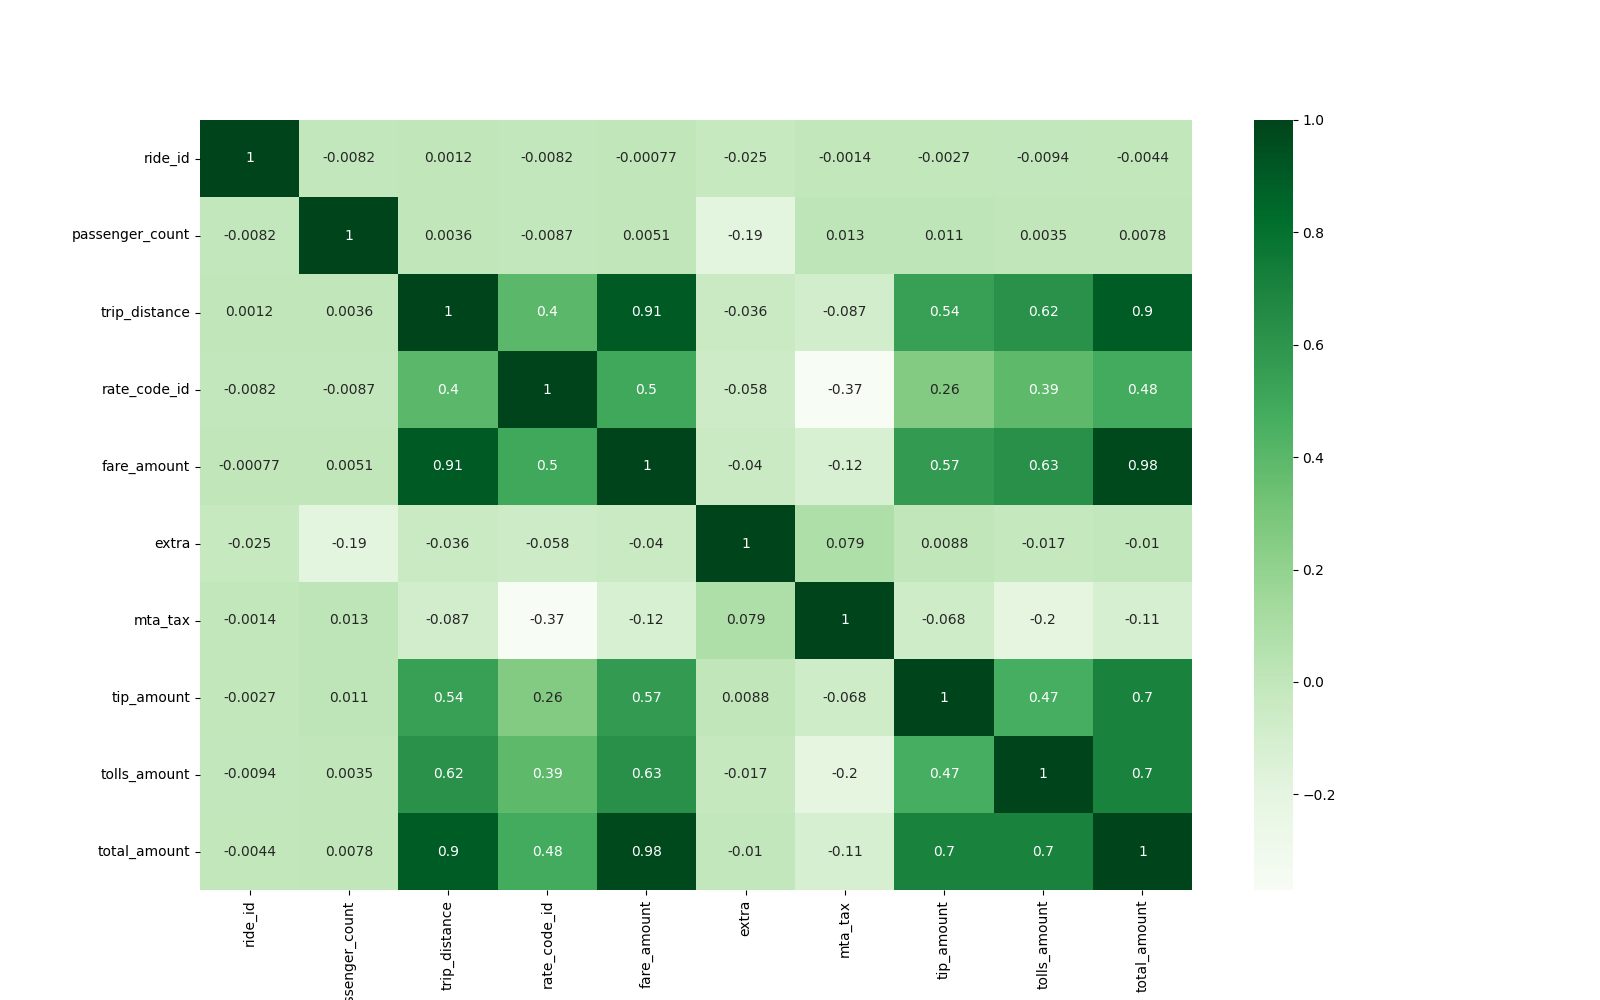

In [13]:
# Perform exploratory data analysis (EDA) on a sample of the data
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd # not sure how the kernel runs, but it looks like I have import pandas again after going back to the notebook after a while

vector_col = 'corr_features'
assembler = VectorAssembler(inputCols=df_sample.columns, outputCol=vector_col)
df_vector = assembler.transform(df_sample).select(vector_col)

matrix = Correlation.corr(df_vector, vector_col).collect()[0][0]
corr_matrix = matrix.toArray().tolist()
corr_matrix_df = pd.DataFrame(data=corr_matrix, columns=df_sample.columns, index=df_sample.columns) 

plt.figure(figsize=(16,10))
sns.heatmap(corr_matrix_df,
            xticklabels=corr_matrix_df.columns.values,
            yticklabels=corr_matrix_df.columns.values,  cmap="Greens", annot=True)

%matplot plt

In [14]:
# Split the dataset into train, validation, and test sets
df_train, df_val, df_test = df_cleaned.randomSplit([0.7, 0.15, 0.15])

In [21]:
# Define the S3 locations to store the datasets
import boto3
import sagemaker

sagemaker_session = sagemaker.Session()
s3_bucket = sagemaker_session.default_bucket()
train_data_prefix = "sandbox/glue-demo/train"
validation_data_prefix = "sandbox/glue-demo/validation"
test_data_prefix = "sandbox/glue-demo/test"
region = boto3.Session().region_name

In [16]:
df_train.write.parquet(f"s3://{s3_bucket}/{train_data_prefix}", mode="overwrite")

In [23]:
df_val.write.parquet(f"s3://{s3_bucket}/{validation_data_prefix}", mode="overwrite")

In [17]:
df_test.write.parquet(f"s3://{s3_bucket}/{test_data_prefix}", mode="overwrite")

In [24]:
from sagemaker import image_uris
from sagemaker.inputs import TrainingInput

hyperparameters = {
        "max_depth":"5",
        "eta":"0.2",
        "gamma":"4",
        "min_child_weight":"6",
        "subsample":"0.7",
        "objective":"reg:squarederror",
        "num_round":"50"}

# Set an output path where the trained model is saved
prefix = 'sandbox/glue-demo'
output_path = f's3://{s3_bucket}/{prefix}/xgb-built-in-algo/output'

# The following line automatically looks for the XGBoost image URI and builds an XGBoost container.
# Version 1.7-1 of the image URI is used. You can specify a version that you prefer.
xgboost_container = sagemaker.image_uris.retrieve("xgboost", region, "1.7-1")

# construct a SageMaker estimator that calls the xgboost-container
estimator = sagemaker.estimator.Estimator(image_uri=xgboost_container,
                                          hyperparameters=hyperparameters,
                                          role=sagemaker.get_execution_role(),
                                          instance_count=1,
                                          instance_type='ml.m5.4xlarge',
                                          output_path=output_path)

content_type = "application/x-parquet"
train_input = TrainingInput(f"s3://{s3_bucket}/{prefix}/train/", content_type=content_type)
validation_input = TrainingInput(f"s3://{s3_bucket}/{prefix}/validation/", content_type=content_type)

# Run the XGBoost training job
estimator.fit({'train': train_input, 'validation': validation_input})

2024-06-14 00:36:26 Starting - Starting the training job...
2024-06-14 00:36:46 Starting - Preparing the instances for training...
2024-06-14 00:37:14 Downloading - Downloading input data...
2024-06-14 00:37:34 Downloading - Downloading the training image...
2024-06-14 00:37:59 Training - Training image download completed. Training in progress...[2024-06-14 00:38:35.919 ip-10-0-229-197.ec2.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2024-06-14 00:38:35.939 ip-10-0-229-197.ec2.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2024-06-14:00:38:36:INFO] Imported framework sagemaker_xgboost_container.training
[2024-06-14:00:38:36:INFO] Failed to parse hyperparameter objective value reg:squarederror to Json.
Returning the value itself
[2024-06-14:00:38:36:INFO] No GPUs detected (normal if no gpus installed)
[2024-06-14:00:38:36:INFO] Running XGBoost Sagemaker in algorithm mode
[2024-06-14:00:38:36:INFO] Determined 0 GPU(s) available on the ins